# Methane emissions from the oil and gas industry in Saskatchewan, Canada
Author: Judith Vogt

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#About-emission-reports" data-toc-modified-id="About-emission-reports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>About emission reports</a></span></li><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Read-emission-reports" data-toc-modified-id="Read-emission-reports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read emission reports</a></span></li><li><span><a href="#Yearly-reported-methane-emissions-per-area" data-toc-modified-id="Yearly-reported-methane-emissions-per-area-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Yearly reported methane emissions per area</a></span></li><li><span><a href="#Emission-factors-for-oil-and-gas-facilities" data-toc-modified-id="Emission-factors-for-oil-and-gas-facilities-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Emission factors for oil and gas facilities</a></span></li></ul></div>

## About emission reports
The oil and gas industry is [Canada's largest emitter of methane](https://www.canada.ca/en/environment-climate-change/services/canadian-environmental-protection-act-registry/factsheet-general-information-regulations-reduction-methane.html). Alberta and Saskatchewan are the country's major oil and gas-producing provinces. Methane is emitted through venting of oil and gas infrastructure, flaring or fugitive emissions. To keep track of yearly emissions, operators have to report emissions of solution gas to the provincial government. These data are reported and made publicly available (for Saskatchwan [here](https://publications.saskatchewan.ca/#/categories/2541)). Emissions in Saskatchewan are divided into four major producing regions - Swift Current, Kindersley, Lloydminster and Estevan - and are reported from venting, flaring and fuel. While all of the vented gas can be associated with methane, only 5% of flared emissions are associated with methane here. Furthermore, we assumed no contribution of methane emissions from fuel. In addition, the methane content of solution gas depends on the region, the gas is produced.

Assumed methane content of solution gas per area:
- Swift Current: 80%
- Kindersley: 85%
- Lloydminster: 90%
- Estevan: 85%

Assumed portion of solution gas associated with methane:
- Flare: 5%
- Vent: 100%

Here, we convert the reported solution gas to methane emissions and visualize them with `seaborn` and an animation.

## Import packages

In [278]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
import seaborn as sns
%matplotlib inline

## Read emission reports

In [123]:
# Get all filenames
files = glob.glob('./20*.xlsx')

# Rename columns
names = ['ID','Operator','Area','Designation','Loc','Code','Type',
         'Flare_facility','Flare_well','Fuel_facility','Fuel_well','Vent_facility','Vent_well','Total_emission']
# Drop columns not needed afterwards
dropcols = ['ID','Loc','Code','Flare_facility','Flare_well','Fuel_facility','Fuel_well',
            'Vent_facility','Vent_well','Total_emission','ch4_content']
li = []

for filename in files:
    # Read excel files and rename columns
    df = pd.read_excel(filename,header=9,names=names,na_values='nan')
    # Add column with year
    year = filename.split('\\')[1].split('%')[0]
    df['Year'] = year
    df.Year = pd.to_numeric(df.Year, errors='coerce').astype('Int64')
    # Select only defined areas
    df = df[(df.Area != '(blank)')]
    df.Area = df.Area.str.split('- ').str[1]
    # Add assumed methane content per region
    df.loc[df.Area=='Swift Current','ch4_content'] = .8
    df.loc[(df.Area=='Kindersley')|(df.Area=='Estevan'),'ch4_content'] = .85
    df.loc[df.Area=='Lloydminster','ch4_content'] = .9
    # Sum facility and well emissions for 100% of vented and 5% of flared solution gas, 
    # select portion of methane. Methane emissions in 10^6 m³/year.
    df['emission']= (df.Vent_well + df.Vent_facility +((df.Flare_well+df.Flare_facility) * .5)) * df.ch4_content / 1000
    # Select only needed columns
    df=df.drop(columns=dropcols)
    # Append data for each year
    li.append(df)

gas = pd.concat(li, axis=0, ignore_index=True)

Yearly sum of reported methane emissions per area:

In [125]:
yearly_gas = gas.groupby(['Area','Year']).sum().reset_index()

## Yearly reported methane emissions per area
Static plot:

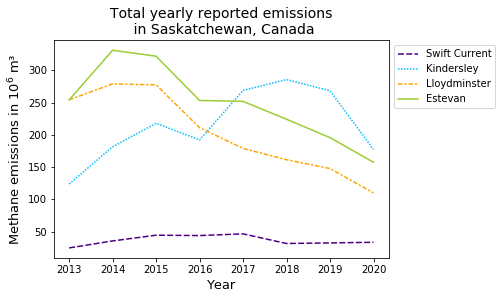

In [284]:
g=sns.lineplot(data=yearly_gas.sort_values('Year'),x='Year',y='emission',hue='Area',
                hue_order=['Swift Current','Kindersley','Lloydminster','Estevan'],
                palette=['indigo','deepskyblue','orange','yellowgreen'],style='Area');
g.set_xlabel('Year',fontsize=13)
g.set_ylabel('Methane emissions in 10$^6$ m³',fontsize=13)
g.set_title('Total yearly reported emissions\n in Saskatchewan, Canada',fontsize=14)
g.legend(bbox_to_anchor=(1,1));

Animation:

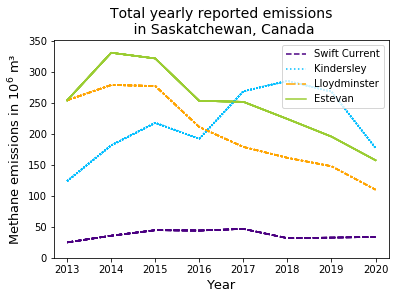

In [288]:
legend_elements = [Line2D([0], [0], ls='dashed',color='indigo', label = 'Swift Current'),
                   Line2D([0], [0], ls='dotted',color='deepskyblue', label='Kindersley'),
                   Line2D([0], [0], ls='dashdot',color='orange', label='Lloydminster'),
                   Line2D([0], [0], ls='solid',color='yellowgreen', label='Estevan')]

fig = plt.figure()
plt.xlim(yearly_gas.Year.min()-.3,yearly_gas.Year.max()+.3)
plt.ylim(0,yearly_gas.emission.max()+20)
plt.xlabel('Year',fontsize=13)
plt.ylabel('Methane emissions in 10$^6$ m³',fontsize=13)
plt.title('Total yearly reported emissions\n in Saskatchewan, Canada',fontsize=14)
plt.legend(handles=legend_elements)

def animate(i):
    data = yearly_gas.set_index('Year').sort_values('Year').iloc[:int(i*4)]
    p = sns.lineplot(x=data.index,y=data.emission,data=data,hue=data.Area,
                     hue_order=['Swift Current','Kindersley','Lloydminster','Estevan'],
                     palette=['indigo','deepskyblue','orange','yellowgreen'],style=data.Area,legend=False)
    
ani = animation.FuncAnimation(fig,animate,frames=15)
#ani.save('emission_animation.gif',writer=animation.PillowWriter()) #save to gif file
ani.save('emission_animation.mp4',writer=animation.FFMpegWriter()) #save to mp4 file

## Emission factors for oil and gas facilities
Emissions are reported per reporting facility. There are also facilities that are reported to emit no methane. Including all the reported numbers (also zeros) for one reporting facility, we obtain an emission factor for this type of facility. There may be certain facility types that usually emit more than others. To reduce methane emissions from the oil and gas industry, it is important to understand which type emits how much methane on average. We show this in the next figure: the bars show the mean emission factor for the indicated facility type, and the errorbars show the 95% confidence interval. As a result, thermal *in situ* batteries in Kindersley on average emit most methane among all facility types in Saskatchewan.

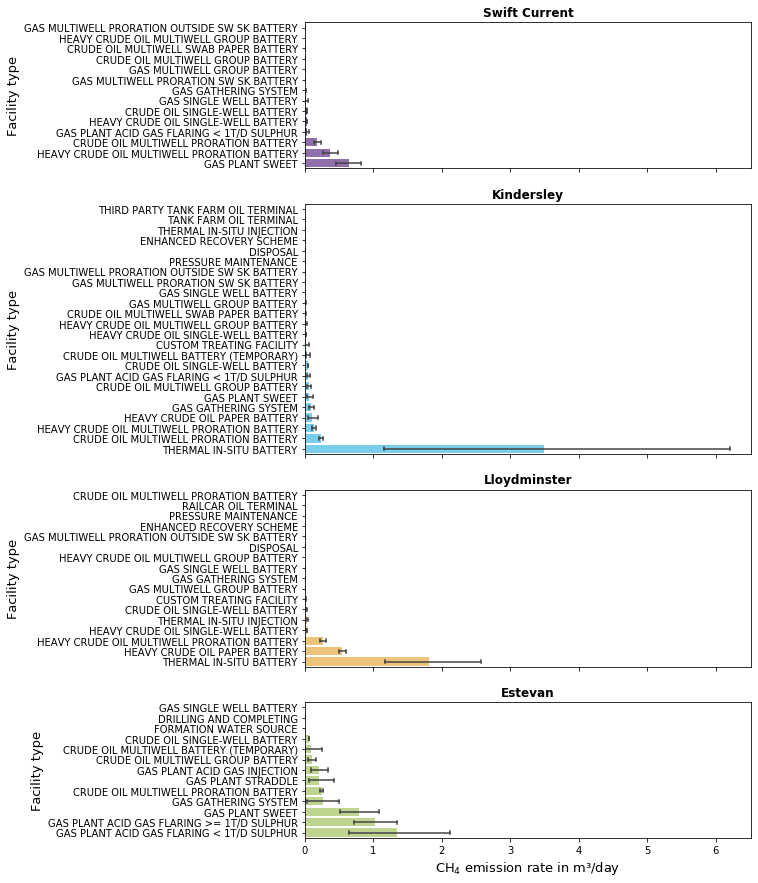

In [298]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,sharex=True,figsize=(8,15),
                               gridspec_kw={'height_ratios': [len(gas.loc[gas.Area=='Swift Current','Type'].unique()),
                                                              len(gas.loc[gas.Area=='Kindersley','Type'].unique()),
                                                              len(gas.loc[gas.Area=='Lloydminster','Type'].unique()),
                                                             len(gas.loc[gas.Area=='Estevan','Type'].unique())]})

sns.barplot(data=gas.loc[(gas.Area=='Swift Current')],
           x='emission',y='Type',ax=ax1,color='indigo',seed=626,alpha=.6,
           order=gas.loc[(gas.Area=='Swift Current')].groupby('Type').mean().emission.sort_values().index.to_list(),
           errwidth=1.5,capsize=.3)
ax1.set_title('Swift Current',weight='semibold')
sns.barplot(data=gas.loc[(gas.Area=='Kindersley')],
           x='emission',y='Type',ax=ax2,color='deepskyblue',seed=626,alpha=.6,
           order=gas.loc[(gas.Area=='Kindersley')].groupby('Type').mean().emission.sort_values().index.to_list(),
           errwidth=1.5,capsize=.3)
ax2.set_title('Kindersley',weight='semibold')
sns.barplot(data=gas.loc[(gas.Area=='Lloydminster')],
           x='emission',y='Type',ax=ax3,color='orange',seed=626,alpha=.6,
           order=gas.loc[(gas.Area=='Lloydminster')].groupby('Type').mean().emission.sort_values().index.to_list(),
           errwidth=1.5,capsize=.3)
ax3.set_title('Lloydminster',weight='semibold')
sns.barplot(data=gas.loc[(gas.Area=='Estevan')],
           x='emission',y='Type',ax=ax4,color='yellowgreen',seed=626,alpha=.6,
           order=gas.loc[(gas.Area=='Estevan')].groupby('Type').mean().emission.sort_values().index.to_list(),
           errwidth=1.5,capsize=.3)
ax4.set_title('Estevan',weight='semibold')
ax1.set_xlabel('')
ax1.set_ylabel('Facility type',fontsize=13)
ax2.set_xlabel('')
ax2.set_ylabel('Facility type',fontsize=13)
ax3.set_xlabel('')
ax3.set_ylabel('Facility type',fontsize=13)
ax4.set_xlabel('CH$_4$ emission rate in m³/day',fontsize=13)
ax4.set_ylabel('Facility type',fontsize=13);